In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

### Loading Data

In [183]:
df = pd.read_csv('data/raw/games.csv')

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71716 entries, 0 to 71715
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       71716 non-null  int64  
 1   Name                        71715 non-null  object 
 2   Release date                71716 non-null  object 
 3   Estimated owners            71716 non-null  object 
 4   Peak CCU                    71716 non-null  int64  
 5   Required age                71716 non-null  int64  
 6   Price                       71716 non-null  float64
 7   DLC count                   71716 non-null  int64  
 8   About the game              69280 non-null  object 
 9   Supported languages         71716 non-null  object 
 10  Full audio languages        71716 non-null  object 
 11  Reviews                     9167 non-null   object 
 12  Header image                71716 non-null  object 
 13  Website                     350

# Data Cleaning

In [185]:
drop_columns = [
    'Header image', 'Website', 'Support url', 'Support email',
    'Metacritic url', 'Screenshots', 'Movies', 'Score rank',
    'Notes', 'Peak CCU', 'DLC count',
    'Full audio languages', 'Reviews',
    'Average playtime two weeks', 'Median playtime two weeks',
    'Support email', 'Support url'
]
df_clean = df.drop(columns=drop_columns)

In [186]:
df_clean.columns.tolist()

['AppID',
 'Name',
 'Release date',
 'Estimated owners',
 'Required age',
 'Price',
 'About the game',
 'Supported languages',
 'Windows',
 'Mac',
 'Linux',
 'Metacritic score',
 'User score',
 'Positive',
 'Negative',
 'Achievements',
 'Recommendations',
 'Average playtime forever',
 'Median playtime forever',
 'Developers',
 'Publishers',
 'Categories',
 'Genres',
 'Tags']

In [187]:
df_clean.head()

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Windows,Mac,...,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Developers,Publishers,Categories,Genres,Tags
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,...,11,30,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,5,12,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,...,8,17,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


In [188]:
mask_not_games = df_clean['Name'].str.lower().str.contains(
    'editor|tool|studio|vegas|magix|acid|server|sdk|benchmark|mod tools|dedicated server|soundtrack|dlc|ost',
    case=False,
    na=False,
    regex=True
)

df_clean = df_clean[~mask_not_games].reset_index(drop=True)

## Preprocessing of text data

In [189]:
def split_tags(tags_str):
    if pd.isna(tags_str) or tags_str == '':
        return []
    return [tag.strip() for tag in str(tags_str).split(',')]

In [190]:
df_clean['Tags_list'] = df_clean['Tags'].apply(split_tags)
df_clean['Genres_list'] = df_clean['Genres'].apply(split_tags) 
df_clean['Categories_list'] = df_clean['Categories'].apply(split_tags)

In [191]:
df_clean['Tags_list'].head(3).values

array([list(['Indie', 'Casual', 'Sports', 'Bowling']),
       list(['Indie', 'Action', 'Pixel Graphics', '2D', 'Retro', 'Arcade', 'Score Attack', 'Minimalist', 'Comedy', 'Singleplayer', 'Fast-Paced', 'Casual', 'Funny', 'Parody', 'Difficult', 'Gore', 'Violent', 'Western', 'Controller', 'Blood']),
       list([])], dtype=object)

## Popular tags analysis

In [192]:
all_tags = []
for tag_list in df_clean['Tags_list']:
    all_tags.extend(tag_list)

In [193]:
tag_counts = pd.Series(all_tags).value_counts()

In [194]:
tag_counts.head(20)

Indie             36641
Singleplayer      28357
Action            25659
Casual            24559
Adventure         23691
2D                15097
Strategy          12170
Simulation        11908
RPG               10519
Puzzle            10021
Atmospheric        9613
3D                 7989
Early Access       7978
Pixel Graphics     7875
Story Rich         7681
Colorful           7376
Multiplayer        6973
Arcade             6805
Cute               6795
First-Person       6423
Name: count, dtype: int64

### Top 20 Most Popular Tags on Steam

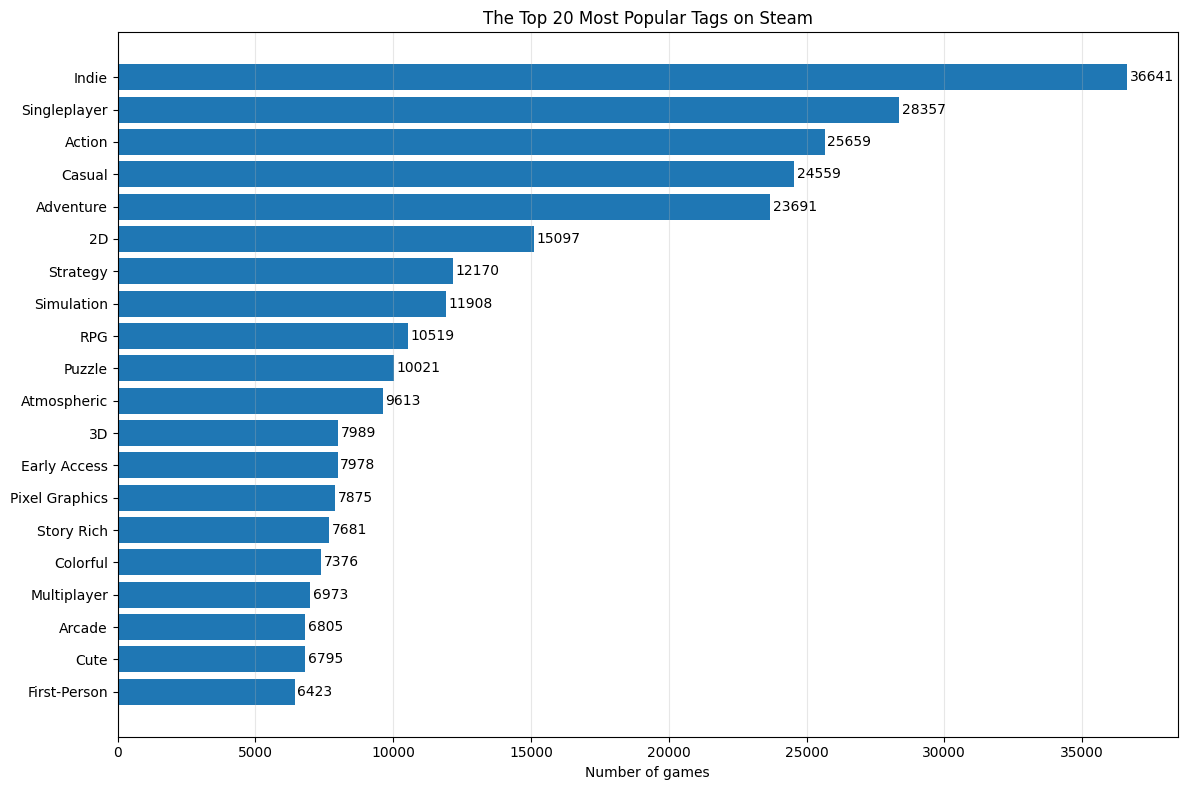

In [195]:
plt.figure(figsize=(12, 8))
top_20 = tag_counts.head(20).sort_values(ascending=True)
bars = plt.barh(range(len(top_20)), top_20.values)

plt.yticks(range(len(top_20)), top_20.index)
plt.title('The Top 20 Most Popular Tags on Steam')
plt.xlabel('Number of games')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', ha='left', va='center')

plt.tight_layout()
plt.show()

### Features for tags

In [196]:
TOP_N_TAGS = 50
useful_tags = tag_counts.head(TOP_N_TAGS).index.tolist()

In [197]:
for tag in useful_tags:
    df_clean[f'tag_{tag}'] = df_clean['Tags_list'].apply(lambda x: 1 if tag in x else 0)

In [198]:
df_clean.head()

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Windows,Mac,...,tag_Top-Down,tag_Violent,tag_Comedy,tag_Visual Novel,tag_FPS,tag_Co-op,tag_Stylized,tag_Controller,tag_2D Platformer,tag_Minimalist
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,...,0,0,0,0,0,0,0,0,0,0
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,1,1,0,0,0,0,1,0,1
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,...,0,0,0,0,0,0,0,0,0,0
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,0,0,0,0,0,1,0,1,0
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,...,0,1,0,0,0,0,0,0,0,0


## Popular genre analysis

In [199]:
all_genres = []
for genre_list in df_clean['Genres_list']:
    all_genres.extend(genre_list)
genre_counts = pd.Series(all_genres).value_counts()

In [200]:
genre_counts.head(10)

Indie           48119
Action          28467
Casual          28434
Adventure       26058
Simulation      13415
Strategy        13073
RPG             11884
Early Access     8202
Free to Play     5560
Sports           3165
Name: count, dtype: int64

### Top 10 most popular genre on steam

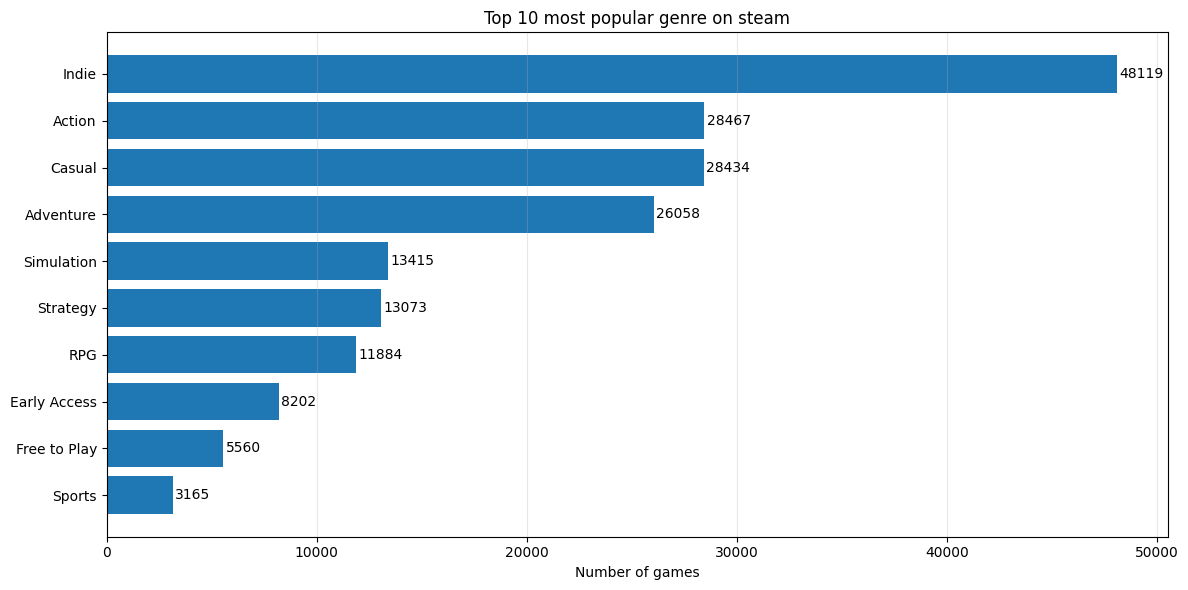

In [201]:
plt.figure(figsize=(12, 6))
top_genres = genre_counts.head(10).sort_values(ascending=True)
bars = plt.barh(range(len(top_genres)), top_genres.values)

plt.yticks(range(len(top_genres)), top_genres.index)
plt.title('Top 10 most popular genre on steam')
plt.xlabel('Number of games')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', ha='left', va='center')

plt.tight_layout()
plt.show()

### Features for genre

In [202]:
for genre in genre_counts.index:
    df_clean[f'genre_{genre}'] = df_clean['Genres_list'].apply(lambda x: 1 if genre in x else 0)

In [203]:
df_clean.head()

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Windows,Mac,...,genre_Sexual Content,genre_Photo Editing,genre_Web Publishing,genre_Accounting,genre_Movie,genre_Documentary,genre_Episodic,genre_Short,genre_Tutorial,genre_360 Video
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,...,0,0,0,0,0,0,0,0,0,0
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,0,0,0,0,0,0,0,0,0
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,...,0,0,0,0,0,0,0,0,0,0
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,0,0,0,0,0,0,0,0,0
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,...,0,0,0,0,0,0,0,0,0,0


## Popular categories analisys

In [204]:
all_categories = []
for cat_list in df_clean['Categories_list']:
    all_categories.extend(cat_list)
category_counts = pd.Series(all_categories).value_counts()

In [205]:
category_counts.head(15)

Single-player                 63936
Steam Achievements            31510
Steam Cloud                   16050
Full controller support       13546
Multi-player                  13351
Steam Trading Cards            9386
Partial Controller Support     9141
PvP                            8425
Co-op                          6592
Steam Leaderboards             6086
Online PvP                     5962
Remote Play Together           5495
Shared/Split Screen            4992
Online Co-op                   3624
Shared/Split Screen PvP        3623
Name: count, dtype: int64

### Top 15 most popular categories

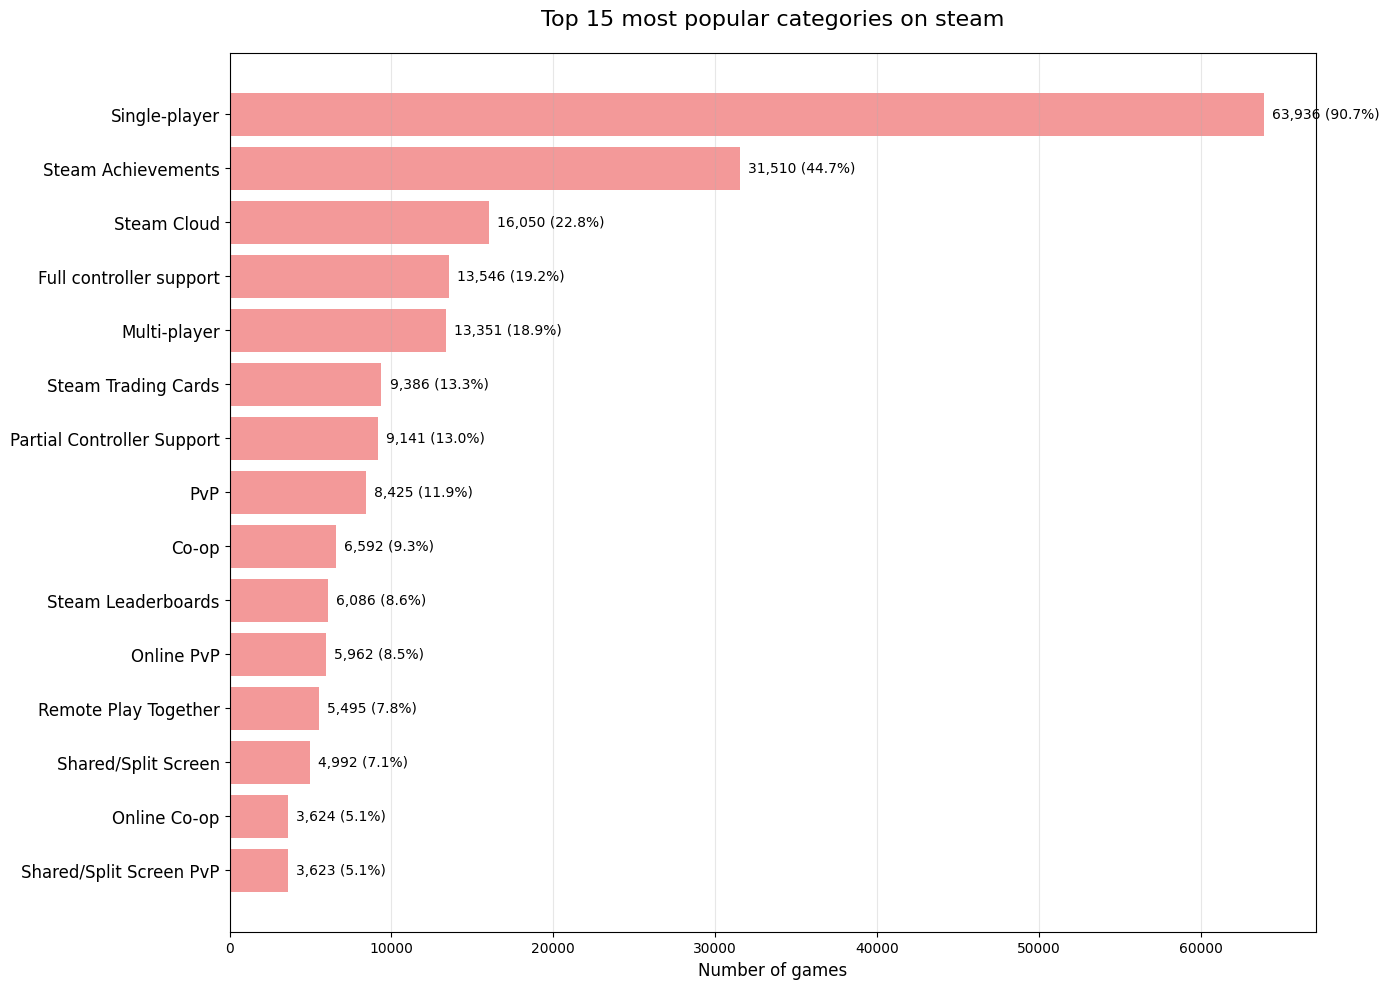

In [206]:
plt.figure(figsize=(14, 10))
top_categories = category_counts.head(15).sort_values(ascending=True)
bars = plt.barh(range(len(top_categories)), top_categories.values, 
                color='lightcoral', alpha=0.8)

plt.yticks(range(len(top_categories)), top_categories.index, fontsize=12)
plt.title('Top 15 most popular categories on steam', fontsize=16, pad=20)
plt.xlabel('Number of games', fontsize=12)
plt.grid(axis='x', alpha=0.3)

total_games = len(df_clean)
for i, bar in enumerate(bars):
    count = int(bar.get_width())
    percentage = (count / total_games) * 100
    plt.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2, 
             f'{count:,} ({percentage:.1f}%)', 
             ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Features for categories

In [207]:
top_categories = category_counts.head(15).index
new_columns = {}
for category in top_categories:
    col_name = f'category_{category.replace(" ", "_").replace("/", "_")}'
    new_columns[col_name] = df_clean['Categories_list'].apply(lambda x: 1 if category in x else 0)

df_clean = pd.concat([df_clean, pd.DataFrame(new_columns)], axis=1)

In [208]:
df_clean.head()

,AppID,Name,Release date,Estimated owners,Required age,Price,About the game,Supported languages,Windows,Mac,...,category_Steam_Trading_Cards,category_Partial_Controller_Support,category_PvP,category_Co-op,category_Steam_Leaderboards,category_Online_PvP,category_Remote_Play_Together,category_Shared_Split_Screen,category_Online_Co-op,category_Shared_Split_Screen_PvP
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],True,False,...,0,1,0,0,0,0,0,0,0,0
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,0,0,0,1,0,0,0,0,0
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",True,False,...,0,0,0,0,0,0,0,0,0,0
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,...,0,0,0,0,0,0,0,0,0,0
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",True,True,...,0,0,0,0,0,0,0,0,0,0


# Create numeric features

## Total reviews and ratio features

In [209]:
df_clean['Total_reviews'] = df_clean['Positive'] + df_clean['Negative']
df_clean['Positive_ratio'] = df_clean['Positive'] / df_clean['Total_reviews']
df_clean['Positive_ratio'] = df_clean['Positive_ratio'].fillna(0)

In [210]:
min_reviews = 100
mask_enough_reviews = df_clean['Total_reviews'] >= min_reviews

In [211]:
min_reviews_free = 1000  # для бесплатных игр выше порог
mask_free_popular = (df_clean['Price'] > 0) | (df_clean['Total_reviews'] >= min_reviews_free)

In [212]:
df_clean = df_clean[mask_enough_reviews & mask_free_popular].reset_index(drop=True)

## Date features

In [213]:
df_clean['Release_year'] = pd.to_datetime(
    df_clean['Release date'], 
    errors='coerce',
    format='mixed'
).dt.year

In [214]:
df_clean['Years_since_release'] = 2025 - df_clean['Release_year']

## Content & support features

In [215]:
df_clean['Description_length'] = df_clean['About the game'].str.len()
df_clean['Language_count'] = df_clean['Supported languages'].apply(lambda x: len(str(x).split(',')))

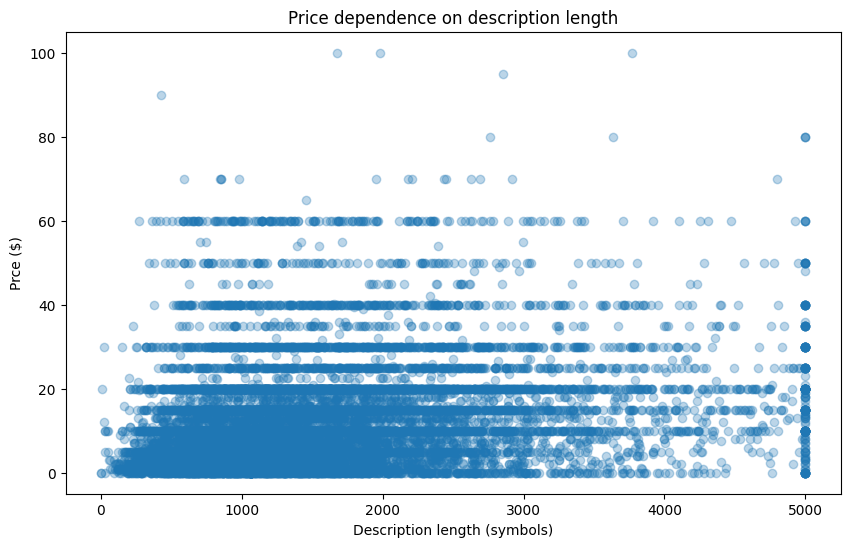

In [216]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Description_length'].clip(0, 5000), 
           df_clean['Price'].clip(0, 100), alpha=0.3)
plt.xlabel('Description length (symbols)')
plt.ylabel('Prce ($)')
plt.title('Price dependence on description length')
plt.show()

In [217]:
df_clean.drop(columns='Description_length', inplace=True)

## Game metrics features

In [218]:
df_clean['Avg_playtime_hours'] = df_clean['Average playtime forever'] / 60
def parse_range(r):
    try:
        low, high = r.split('-')
        return (int(low.strip()) + int(high.strip())) / 2
    except:
        return 0 

df_clean['Estimated_owners_num'] = df_clean['Estimated owners'].apply(parse_range)

# Filtering data

In [219]:
ml_columns = (
    [col for col in df_clean.columns if col.startswith('tag_')] +
    [col for col in df_clean.columns if col.startswith('genre_')] +
    [col for col in df_clean.columns if col.startswith('category_')] +
    ['Total_reviews', 'Positive_ratio', 'Release_year', 'Years_since_release', 
     'Language_count', 'Avg_playtime_hours', 'Achievements', 'Price', 'Required age',
     'AppID', 'Name', 'Estimated_owners_num']
)

filter_df = df_clean[ml_columns]

In [220]:
for col, count in filter_df.isnull().sum().items():
    if count > 0:
        percent = (count / len(df_clean)) * 100
        print(f"{col}: {count} passes ({percent:.1f}%)")

In [221]:
filter_df = filter_df[filter_df['Name'].notna()]

In [222]:
filter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Columns: 110 entries, tag_Indie to Estimated_owners_num
dtypes: float64(4), int32(2), int64(103), object(1)
memory usage: 12.0+ MB


# Model

In [223]:
X = filter_df.drop(columns=['Name', 'AppID'])

In [224]:
game_names = filter_df['Name']
game_ids = filter_df['AppID']

In [225]:
feature_cols = [col for col in X.columns if col.startswith(('tag_', 'genre_', 'category_'))]
X_features = X[feature_cols]

In [226]:
common = X_features.sum()[lambda x: x >= 10].index
X_features = X_features[common]

In [227]:
X_norm = normalize(X_features, norm='l2')

In [228]:
model = NearestNeighbors(n_neighbors=11, metric='cosine', algorithm='brute')
model.fit(X_norm)

,n_neighbors,11
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


# Real test

In [288]:
def normalize_name(name):
    name = re.sub(r'[®™©]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

In [297]:
def remove_edition_tags(name):
    editions = [
        'goty', 'game of the year', 'deluxe', 'ultimate', 'gold', 
        'premium', 'enhanced', 'definitive', 'complete', 'remastered',
        'special edition', 'collector', 'digital deluxe', 'directors cut',
        'standard edition', 'day one edition'
    ]
    
    base = normalize_name(name).lower()
    for edition in editions:
        base = base.replace(edition, '').strip()
    
    base = ' '.join(base.split())
    base = base.replace(' -', '').replace('- ', '').replace(':', '').strip()
    return base

In [298]:
def find_game(game_name):
    search_name = normalize_name(game_name)
    normalized_names = game_names.apply(normalize_name)
    
    matches_mask = normalized_names.str.contains(search_name, case=False, na=False, regex=False)
    matches = game_names[matches_mask]
    
    # Не найдено
    if len(matches) == 0:
        print(f"❌ Game '{game_name}' not found\n")
        _show_suggestions(search_name, normalized_names)
        return None
    
    # Найдено несколько
    if len(matches) > 1:
        print(f"🔍 Found {len(matches)} games:\n")
        for i, name in enumerate(matches.head(10), 1):
            print(f"   {i}. {name}")
        print(f"\n Perhaps you meant: {matches.iloc[0]}\n")
    
    return matches.index[0]

In [299]:
def _show_suggestions(search_name, normalized_names):
    first_word = search_name.split()[0] if search_name.split() else search_name
    print(f"🔍 Perhaps you meant (search for '{first_word}'):\n")
    
    similar_mask = normalized_names.str.lower().str.contains(
        first_word.lower(), case=False, na=False, regex=False
    )
    similar = game_names[similar_mask].head(10)
    
    if len(similar) > 0:
        for i, name in enumerate(similar, 1):
            print(f"   {i}. {name}")
    else:
        print("Not found!")

In [300]:
def get_unique_recommendations(idx, n):
    distances, indices = model.kneighbors(X_norm[idx:idx+1], n_neighbors=n*3)
    
    seen_games = set()
    results = []
    
    for i, dist in zip(indices[0][1:], distances[0][1:]):
        if len(results) >= n:
            break
        
        base_name = remove_edition_tags(game_names.iloc[i])
        
        if base_name in seen_games:
            continue
        
        seen_games.add(base_name)
        results.append((i, dist))
    
    return results

In [301]:
def print_recommendations(game_idx, recommendations):
    print(f"🎮 Recommendations for '{game_names.iloc[game_idx]}':\n")
    
    for rank, (i, dist) in enumerate(recommendations, 1):
        game = game_names.iloc[i]
        rating = filter_df.iloc[i]['Positive_ratio']
        similarity = 1 - dist
        
        print(f"   {rank}. {game}")
        print(f"       ⭐ {rating:.1%} | 📊 Similarity: {similarity:.3f}\n")

In [304]:
def recommend(game_name, n=10):
    idx = find_game(game_name)
    if idx is None:
        return None
        
    recommendations = get_unique_recommendations(idx, n)
    print_recommendations(idx, recommendations)

In [313]:
recommend('Far cry')

🔍 Found 8 games:

   1. Far Cry® 5
   2. Far Cry® 4
   3. Far Cry 3 - Blood Dragon
   4. Far Cry® Primal
   5. Far Cry® New Dawn
   6. Far Cry 3
   7. Far Cry®
   8. Far Cry® 2

 Perhaps you meant: Far Cry® 5

🎮 Recommendations for 'Far Cry® 5':

   1. Far Cry® 4
       ⭐ 82.9% | 📊 Similarity: 0.906

   2. Far Cry 3
       ⭐ 90.1% | 📊 Similarity: 0.858

   3. Far Cry® 2
       ⭐ 77.6% | 📊 Similarity: 0.854

   4. Generation Zero®
       ⭐ 67.9% | 📊 Similarity: 0.845

   5. Far Cry® New Dawn
       ⭐ 76.9% | 📊 Similarity: 0.837

   6. Homefront®: The Revolution
       ⭐ 59.0% | 📊 Similarity: 0.837

   7. Sea of Thieves
       ⭐ 90.3% | 📊 Similarity: 0.818

   8. Red Dead Redemption 2
       ⭐ 88.5% | 📊 Similarity: 0.818

   9. Enemy Front
       ⭐ 65.1% | 📊 Similarity: 0.804

   10. Homefront
       ⭐ 60.1% | 📊 Similarity: 0.804

